## Reading dataset

In [ ]:
import csv
import numpy as np
import matplotlib.pyplot as plt
import itertools
from functools import partial

def process_row(row):
    *attributes, klass = row
    attributes = np.array(attributes, dtype=float)
    klass = 1 if klass == 'P' else -1
    return attributes, klass


def read_dataset(name):
    header = []

    attributes = []
    klasses = []

    with open('/content/drive/My Drive/Универ/ML/{}.csv'.format(name)) as dataset_file:
        dataset_reader = csv.reader(dataset_file)
        header = next(dataset_reader)
        for row in dataset_reader:
            attrs, klass = process_row(row)
            attributes.append(attrs)
            klasses.append(klass)

    attributes = np.array(attributes, dtype=float)
    klasses = np.array(klasses, dtype=int)

    return header, attributes, klasses

## Kernels

In [ ]:
def create_power_kernel(n):
    return partial(kernel_power_n, n=n)


def create_poly_kernel(n):
    return partial(kernel_poly_n, n=n)


def create_rbf_kernel(gamma):
    return partial(kernel_rbf, gamma=gamma)


def create_tanh_kernel(v):
    return partial(kernel_tanh, v=v)


def kernel_power_n(x, y, n=1):
    return np.dot(x, y.T) ** n


def kernel_poly_n(x, y, n=2):
    return (np.dot(x, y.T) + 1) ** n


def kernel_rbf(x, y, gamma=1):
    return np.exp(-gamma * np.linalg.norm(x[:, None, :] - y[None, :, :], axis=-1)) 

## SVM

In [ ]:
PREC = 1e-6
ITERS = 100


def np_evaluate_L(a, distances, klasses, kernel):
    print('evaluating ', a)
    return -a.sum() + (a * klasses).T @ distances @ (a * klasses) / 2


def clip(value, vmin, vmax):
    return vmin if value < vmin else vmax if value > vmax else value


def np_calc_svm(distances, klasses, c):
    rng = np.random.Generator(np.random.PCG64(42))

    n_objects = distances.shape[0]

    a = np.zeros(n_objects)
    b = 0.
    
    for _ in range(ITERS):
        had_violation = False
        for first in range(n_objects):
            pred_first = distances[first] @ (a * klasses) - b

            KTT = True
            if a[first] < PREC:
                KTT = pred_first * klasses[first] >= 1 - PREC
            elif a[first] > c - PREC:
                KTT = pred_first * klasses[first] <= 1 + PREC
            else:
                KTT = 1 - PREC <= pred_first * klasses[first] <= 1 + PREC

            if KTT:
                continue
            had_violation = True

            second = rng.integers(n_objects)
            if second == first:
                continue

            pred_second = distances[second] @ (a * klasses) - b

            k11 = distances[first][first]
            k22 = distances[second][second]
            k12 = distances[first][second]
            error1 = pred_first - klasses[first];
            error2 = pred_second - klasses[second];
            derror = error1 - error2;
            eta = k11 + k22 - 2 * k12

            s = klasses[second] * klasses[first]

            high = 0
            low = 0
            if s == 1:
                high = min(c, a[first] + a[second])
                low = max(0, a[first] + a[second] - c)
            else:
                high = min(c, c + a[second] - a[first])
                low = max(0, a[second] - a[first])

            if eta < PREC:
                f1 = klasses[first] * (error1 + b) - a[first] * k11 - s * a[second] * k12
                f2 = klasses[second] * (error2 + b) - s * a[first] * k12 - a[second] * k22
                L1 = a[first] + s * (a[second] - low)
                H1 = a[first] + s * (a[second] - high)
                PHI_L = L1 * f1 + low * f2 + 0.5 * L1**2 * k11 + 0.5 * low**2 * k22 + s * low * L1 * k12
                PHI_H = H1 * f1 + high * f2 + 0.5 * H1**2 * k11 + 0.5 * high**2 * k22 + s * high * H1 * k12
                
                if PHI_L < PHI_H:
                    asecond = low
                else:
                    asecond = high
            else:
                asecond = clip(a[second] + klasses[second] * derror / eta, low, high)
            
            afirst = a[first] + s * (a[second] - asecond)

            b1 = error1 + klasses[first] * (afirst - a[first]) * k11 + klasses[second] * (asecond - a[second]) * k12 + b
            b2 = error2 + klasses[first] * (afirst - a[first]) * k12 + klasses[second] * (asecond - a[second]) * k22 + b
            b = (b1 + b2) / 2

            a[second] = asecond
            a[first] = afirst

        if not had_violation:
            break

    return a, b

## Optimization

In [ ]:
def maximize(function, *args):
    max_error = None
    best_params = None
    for hyperparams in itertools.product(*args):
        error = function(hyperparams)
        if max_error is None or error > max_error:
            max_error = error
            best_params = hyperparams

    return best_params


def split_k_fold(attributes, klasses, k=5):
    splits = []
    for offset in range(k):
        mask = np.arange(offset, len(attributes), k)
        training_attrs = np.delete(attributes, mask, axis=0)
        training_klasses = np.delete(klasses, mask)

        test_attrs = attributes[mask]
        test_klasses = klasses[mask]

        splits.append((training_attrs, training_klasses, test_attrs, test_klasses))
    
    return splits


def calc_f_score(predictions, klasses):
    tp = predictions[(predictions == 1) & (klasses == 1)].size
    fp = predictions[(predictions == 1) & (klasses == -1)].size
    fn = predictions[(predictions == -1) & (klasses == 1)].size

    prec = tp / (tp + fp) if tp > 0 else 0
    rec = tp / (tp + fn) if tp > 0 else 0

    f_score = 2 * prec * rec / (prec + rec) if prec > 0 else 0
    return f_score


def evaluate_kernel(attributes, klasses, kernel, c):
    splits = split_k_fold(attributes, klasses)

    all_predictions = np.empty(0)
    all_klasses = np.empty(0)

    for training_attrs, training_klasses, test_attrs, test_klasses in splits:
        n_objects = training_attrs.shape[0]
        distances = kernel(training_attrs, training_attrs)

        a, b = np_calc_svm(distances, training_klasses, c)

        n_test_objects = test_attrs.shape[0]
        test_distances = kernel(test_attrs, training_attrs)

        predictions = np.sign(test_distances @ (a * training_klasses))
        all_predictions = np.append(all_predictions, predictions)
        all_klasses = np.append(all_klasses, test_klasses)

    return calc_f_score(all_predictions, all_klasses)


def optimize_power(name):
    _, attributes, klasses = read_dataset(name)

    def function(hyperparams):
        n, c = hyperparams
        kernel = create_power_kernel(n)
        score = evaluate_kernel(attributes, klasses, kernel, c)
        print(score, '@', hyperparams)
        return score

    space = np.arange(1, 11)
    cs = np.logspace(-2, 2, num = 13)

    params = maximize(function, space, cs)
    print(params)


def optimize_poly(name):
    _, attributes, klasses = read_dataset(name)

    def function(hyperparams):
        n, c = hyperparams
        kernel = create_poly_kernel(n)
        score = evaluate_kernel(attributes, klasses, kernel, c)
        print(score, '@', hyperparams)
        return score

    space = np.arange(1, 11)
    cs = np.logspace(-2, 2, num = 13)

    params = maximize(function, space, cs)
    print(params)


def optimize_rbf(name):
    _, attributes, klasses = read_dataset(name)

    def function(hyperparams):
        gamma, c = hyperparams
        kernel = create_rbf_kernel(gamma)
        score = evaluate_kernel(attributes, klasses, kernel, c)
        print(score, '@', hyperparams)
        return score

    space = np.linspace(0, 10, num=51)
    cs = np.logspace(-2, 2, num = 13)

    params = maximize(function, space, cs)
    print(params)

## Visualization

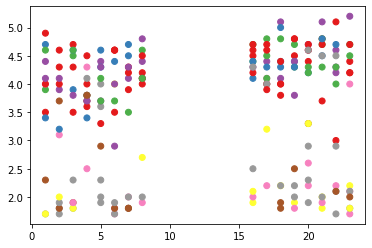

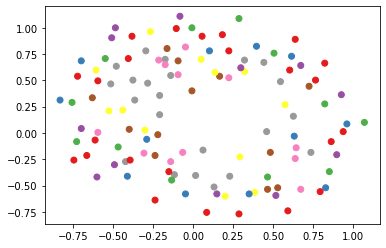

In [ ]:
def plot_contours(attributes, klasses, a, b, kernel, h=0.2):
    x_min, x_max = attributes[:, 0].min() - 0.5, attributes[:, 0].max() + 0.5
    y_min, y_max = attributes[:, 1].min() - 0.5, attributes[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    grid = np.c_[xx.ravel(), yy.ravel()]
    n_points = grid.shape[0]
    n_objects = attributes.shape[0]

    distances = kernel(grid, attributes)

    z = np.clip(distances @ (a * klasses) - b, -1, 1)

    z = z.reshape(xx.shape)
    plt.contourf(xx, yy, z)


def visualize_splits(name):
    _, attributes, klasses = read_dataset(name)
    splits = split_k_fold(attributes, klasses)
    group = 0.1
    for offset in range(5):
        mask = np.arange(offset, len(attributes), 5)
        klasses[mask] *= offset + 1
        # plt.show()
        group += 0.1

    plt.scatter(attributes[:, 0], attributes[:, 1], c=klasses, cmap='Set1')
    plt.show()

visualize_splits('geyser')
visualize_splits('chips')

## Running SVM

In [ ]:
def run_svm(attributes, klasses, kernel, c):
    n_objects = klasses.size
    distances = kernel(attributes, attributes)

    a, b = np_calc_svm(distances, klasses, c)

    predictions = np.sign(distances @ (a * klasses) - b)
    f_score = calc_f_score(predictions, klasses)

    print('Correctly identified', predictions[predictions == klasses].size, 'of', klasses.size)
    print('F-score', f_score)

    plot_contours(attributes, klasses, a, b, kernel)
    plt.scatter(attributes[:, 0], attributes[:, 1], c=klasses, cmap='bwr')
    plt.show()


def np_main():
    attributes = np.array([[1, 1],
                           [3, 2],
                           [1, 4],
                           [2, 3]])
    klasses = np.array([1, 1, -1, -1])

    for kernel in [np.dot, kernel_poly_2, kernel_poly_3, kernel_poly_4, kernel_poly_5, kernel_rbf, kernel_tanh]:
        run_svm(attributes, klasses, kernel)

## Geyser

Correctly identified 198 of 222
F-score 0.8441558441558441


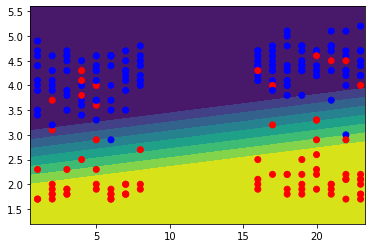

Correctly identified 171 of 222
F-score 0.7536231884057971


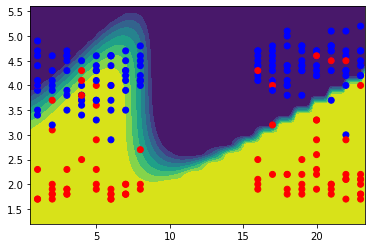

Correctly identified 151 of 222
F-score 0.5419354838709678


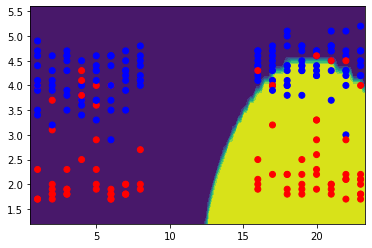

Correctly identified 200 of 222
F-score 0.8589743589743591


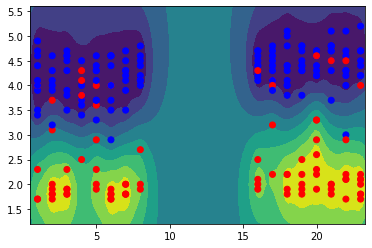

In [185]:
def plot_geyser():
    _, attributes, klasses = read_dataset('geyser')
    for kernel, c in [(create_power_kernel(1), 1), 
                      (create_power_kernel(4), 1),
                      (create_poly_kernel(5), 100),
                      (create_rbf_kernel(1.2), 0.21544346900318834)]:
        run_svm(attributes, klasses, kernel, c)


plot_geyser()

### Power optimization

In [ ]:
optimize_power('geyser')

0 @ (1, 0.01)
0 @ (1, 0.021544346900318832)
0 @ (1, 0.046415888336127774)
0 @ (1, 0.1)
0 @ (1, 0.21544346900318834)
0 @ (1, 0.46415888336127775)
0 @ (1, 1.0)
0 @ (1, 2.154434690031882)
0 @ (1, 4.6415888336127775)
0 @ (1, 10.0)
0 @ (1, 21.54434690031882)
0.18556701030927836 @ (1, 46.41588833612777)
0.1276595744680851 @ (1, 100.0)
0.18556701030927836 @ (2, 0.01)
0.22000000000000003 @ (2, 0.021544346900318832)
0 @ (2, 0.046415888336127774)
0.04395604395604396 @ (2, 0.1)
0.30476190476190473 @ (2, 0.21544346900318834)
0 @ (2, 0.46415888336127775)
0.24761904761904763 @ (2, 1.0)
0.1075268817204301 @ (2, 2.154434690031882)
0.348993288590604 @ (2, 4.6415888336127775)
0.1075268817204301 @ (2, 10.0)
0.37168141592920356 @ (2, 21.54434690031882)
0.1075268817204301 @ (2, 46.41588833612777)
0.1263157894736842 @ (2, 100.0)
0.5190839694656488 @ (3, 0.01)
0.41739130434782606 @ (3, 0.021544346900318832)
0.46715328467153283 @ (3, 0.046415888336127774)
0.47619047619047616 @ (3, 0.1)
0.35185185185185186 @ (

### Poly optimization

In [ ]:
optimize_poly('geyser')

0 @ (1, 0.01)
0 @ (1, 0.021544346900318832)
0 @ (1, 0.046415888336127774)
0 @ (1, 0.1)
0 @ (1, 0.21544346900318834)
0 @ (1, 0.46415888336127775)
0 @ (1, 1.0)
0 @ (1, 2.154434690031882)
0 @ (1, 4.6415888336127775)
0 @ (1, 10.0)
0.02247191011235955 @ (1, 21.54434690031882)
0.02247191011235955 @ (1, 46.41588833612777)
0.16666666666666669 @ (1, 100.0)
0.16494845360824742 @ (2, 0.01)
0.044444444444444446 @ (2, 0.021544346900318832)
0.41739130434782606 @ (2, 0.046415888336127774)
0.202020202020202 @ (2, 0.1)
0.20408163265306123 @ (2, 0.21544346900318834)
0.2222222222222222 @ (2, 0.46415888336127775)
0.1276595744680851 @ (2, 1.0)
0 @ (2, 2.154434690031882)
0.2641509433962264 @ (2, 4.6415888336127775)
0.21782178217821782 @ (2, 10.0)
0.2580645161290322 @ (2, 21.54434690031882)
0.044444444444444446 @ (2, 46.41588833612777)
0.4264705882352941 @ (2, 100.0)
0.5970149253731344 @ (3, 0.01)
0.5443037974683544 @ (3, 0.021544346900318832)
0.5189873417721519 @ (3, 0.046415888336127774)
0.5380116959064327

### RBF optimization

In [ ]:
optimize_rbf('geyser')

0 @ (0.0, 0.01)
0.5148514851485149 @ (0.0, 0.021544346900318832)
0 @ (0.0, 0.046415888336127774)
0.3505154639175258 @ (0.0, 0.1)
0 @ (0.0, 0.21544346900318834)
0 @ (0.0, 0.46415888336127775)
0 @ (0.0, 1.0)
0 @ (0.0, 2.154434690031882)
0.5591397849462366 @ (0.0, 4.6415888336127775)
0 @ (0.0, 10.0)
0.47133757961783435 @ (0.0, 21.54434690031882)
0 @ (0.0, 46.41588833612777)
0 @ (0.0, 100.0)
0.8535031847133757 @ (0.2, 0.01)
0.8535031847133757 @ (0.2, 0.021544346900318832)
0.8535031847133757 @ (0.2, 0.046415888336127774)
0.8535031847133757 @ (0.2, 0.1)
0.8535031847133757 @ (0.2, 0.21544346900318834)
0.8535031847133757 @ (0.2, 0.46415888336127775)
0.8589743589743591 @ (0.2, 1.0)
0.8516129032258065 @ (0.2, 2.154434690031882)
0.8407643312101911 @ (0.2, 4.6415888336127775)
0.8322981366459626 @ (0.2, 10.0)
0.8271604938271605 @ (0.2, 21.54434690031882)
0.8242424242424242 @ (0.2, 46.41588833612777)
0.8117647058823529 @ (0.2, 100.0)
0.8535031847133757 @ (0.4, 0.01)
0.8535031847133757 @ (0.4, 0.0215

## Chips

Correctly identified 66 of 118
F-score 0.6904761904761904


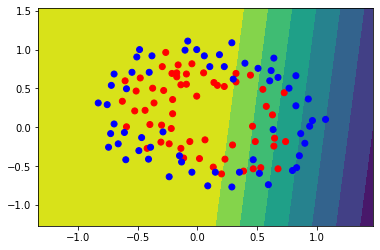

Correctly identified 73 of 118
F-score 0.7169811320754716


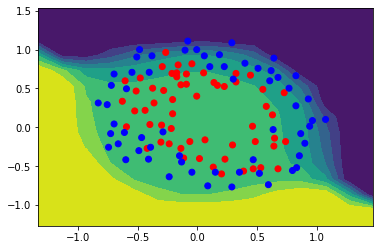

Correctly identified 101 of 118
F-score 0.8682170542635659


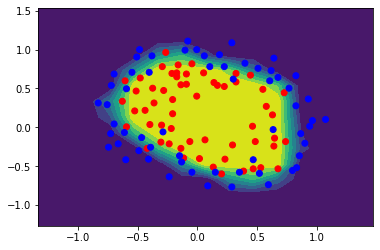

Correctly identified 110 of 118
F-score 0.9310344827586207


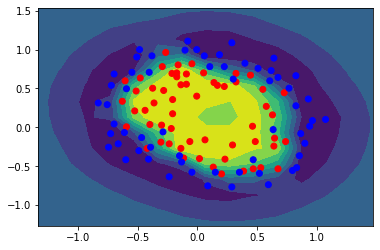

In [177]:
def plot_chips():
    _, attributes, klasses = read_dataset('chips')
    for kernel, c in [(create_power_kernel(1), 4.6415888336127775), 
                      (create_power_kernel(7), 0.1),
                      (create_poly_kernel(7), 1),
                      (create_rbf_kernel(5.0), 1.0)]:
        run_svm(attributes, klasses, kernel, c)

plot_chips()

### Power optimization

In [ ]:
optimize_power('chips')

0.5378151260504203 @ (1, 0.01)
0.547008547008547 @ (1, 0.021544346900318832)
0.5423728813559322 @ (1, 0.046415888336127774)
0.5423728813559322 @ (1, 0.1)
0.547008547008547 @ (1, 0.21544346900318834)
0.5423728813559322 @ (1, 0.46415888336127775)
0.5499999999999999 @ (1, 1.0)
0.5087719298245614 @ (1, 2.154434690031882)
0.576271186440678 @ (1, 4.6415888336127775)
0.547008547008547 @ (1, 10.0)
0.5132743362831858 @ (1, 21.54434690031882)
0.5423728813559322 @ (1, 46.41588833612777)
0.5254237288135593 @ (1, 100.0)
0 @ (2, 0.01)
0 @ (2, 0.021544346900318832)
0 @ (2, 0.046415888336127774)
0 @ (2, 0.1)
0 @ (2, 0.21544346900318834)
0 @ (2, 0.46415888336127775)
0 @ (2, 1.0)
0 @ (2, 2.154434690031882)
0 @ (2, 4.6415888336127775)
0 @ (2, 10.0)
0 @ (2, 21.54434690031882)
0 @ (2, 46.41588833612777)
0 @ (2, 100.0)
0.37623762376237624 @ (3, 0.01)
0.39215686274509803 @ (3, 0.021544346900318832)
0.39215686274509803 @ (3, 0.046415888336127774)
0.39215686274509803 @ (3, 0.1)
0.39215686274509803 @ (3, 0.2154

### Poly optimization

In [ ]:
optimize_poly('chips')

0.5378151260504203 @ (1, 0.01)
0.547008547008547 @ (1, 0.021544346900318832)
0.5423728813559322 @ (1, 0.046415888336127774)
0.5423728813559322 @ (1, 0.1)
0.547008547008547 @ (1, 0.21544346900318834)
0.5423728813559322 @ (1, 0.46415888336127775)
0.5499999999999999 @ (1, 1.0)
0.5087719298245614 @ (1, 2.154434690031882)
0.576271186440678 @ (1, 4.6415888336127775)
0.547008547008547 @ (1, 10.0)
0.5132743362831858 @ (1, 21.54434690031882)
0.5423728813559322 @ (1, 46.41588833612777)
0.5254237288135593 @ (1, 100.0)
0.3380281690140845 @ (2, 0.01)
0.3380281690140845 @ (2, 0.021544346900318832)
0.3380281690140845 @ (2, 0.046415888336127774)
0.3380281690140845 @ (2, 0.1)
0.15873015873015872 @ (2, 0.21544346900318834)
0 @ (2, 0.46415888336127775)
0 @ (2, 1.0)
0 @ (2, 2.154434690031882)
0 @ (2, 4.6415888336127775)
0 @ (2, 10.0)
0 @ (2, 21.54434690031882)
0 @ (2, 46.41588833612777)
0 @ (2, 100.0)
0.06666666666666667 @ (3, 0.01)
0.06666666666666667 @ (3, 0.021544346900318832)
0.06666666666666667 @ (3,

### RBF optimization

In [ ]:
optimize_rbf('chips')

0 @ (0.0, 0.01)
0 @ (0.0, 0.021544346900318832)
0 @ (0.0, 0.046415888336127774)
0.6744186046511628 @ (0.0, 0.1)
0 @ (0.0, 0.21544346900318834)
0 @ (0.0, 0.46415888336127775)
0 @ (0.0, 1.0)
0 @ (0.0, 2.154434690031882)
0 @ (0.0, 4.6415888336127775)
0 @ (0.0, 10.0)
0 @ (0.0, 21.54434690031882)
0 @ (0.0, 46.41588833612777)
0 @ (0.0, 100.0)
0.6590909090909091 @ (0.2, 0.01)
0.6590909090909091 @ (0.2, 0.021544346900318832)
0.6590909090909091 @ (0.2, 0.046415888336127774)
0.6590909090909091 @ (0.2, 0.1)
0.6590909090909091 @ (0.2, 0.21544346900318834)
0.6590909090909091 @ (0.2, 0.46415888336127775)
0.6590909090909091 @ (0.2, 1.0)
0.6590909090909091 @ (0.2, 2.154434690031882)
0.6590909090909091 @ (0.2, 4.6415888336127775)
0.6590909090909091 @ (0.2, 10.0)
0.6590909090909091 @ (0.2, 21.54434690031882)
0.6590909090909091 @ (0.2, 46.41588833612777)
0.6590909090909091 @ (0.2, 100.0)
0.6590909090909091 @ (0.4, 0.01)
0.6590909090909091 @ (0.4, 0.021544346900318832)
0.6590909090909091 @ (0.4, 0.0464158